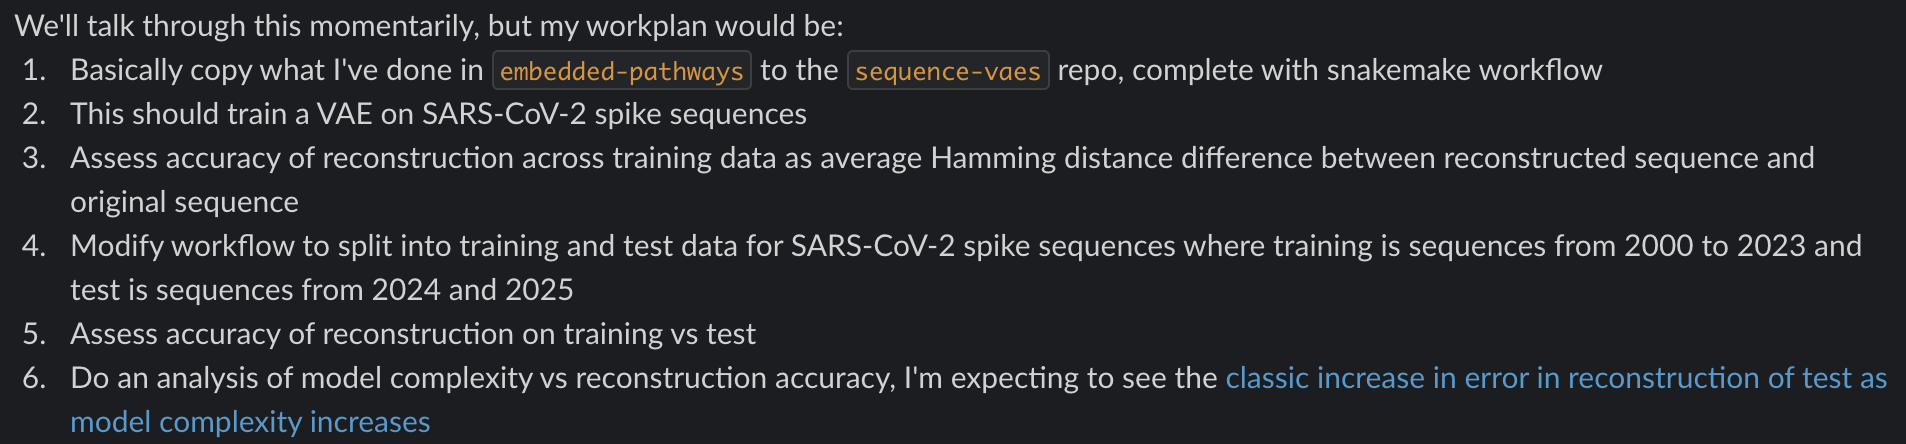

In [9]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [10]:
# path to sequence_vaes directory
# abspath = "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
abspath = ".."

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

# path to sequence_vaes directory and pip install
# %cd "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
# !pip install -r requirements.txt

In [12]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [13]:
BATCH_SIZE = 64

# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/data/training/training_aligned.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## loss figures

In [15]:
train_logs = []
valid_logs = []
with open("./results/train_logs.json", "r") as f:
    train_logs = json.load(f)[1:55]

with open("./results/valid_logs.json","r") as f:
    valid_logs = json.load(f)[1:55]

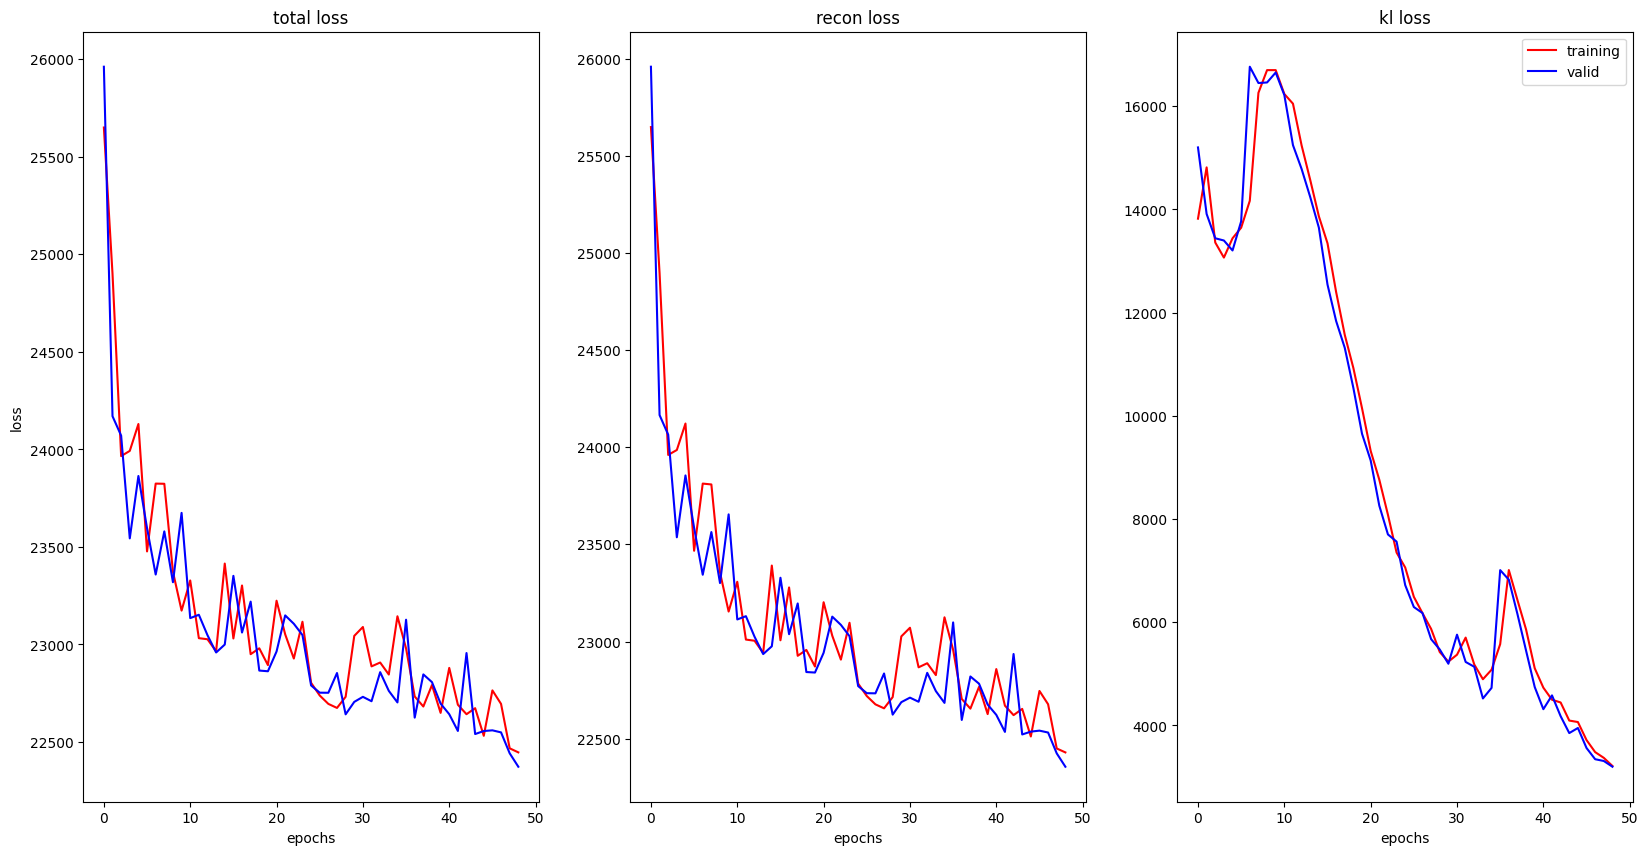

In [16]:
labels = ["total", "recon", "kl"]
colors = ["red", "blue"]

fig,arr = plt.subplots(1,3,figsize=(20,10))

N = len(train_logs)
for i in range(3):
    arr[i].plot(list(range(N)), [x[i] for x in train_logs], color=colors[0], label="training")
    arr[i].plot(list(range(N)), [x[i] for x in valid_logs], color=colors[1], label="valid")
    arr[i].set_title("%s loss"%labels[i])
    arr[i].set_xlabel("epochs")
    if i == 0:
        arr[i].set_ylabel("loss")

plt.legend()
fig.show()

## Embedding space Visualizations

In [18]:
# input_dim = len(ALPHABET) * SEQ_LENGTH
input_dim = 29903 * 5
# input_dim = 29903
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True))

<All keys matched successfully>

In [19]:
dataset = DNADataset(f"{abspath}/data/valid/valid_aligned.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/valid/valid_metadata.tsv", sep="\t")
with open(f"{abspath}/data/valid/valid_aligned.fasta", "r") as f:
  doc = f.readlines()
  vals = []
  for d in doc:
    if ">" == d[0]:
      vals.append(d[1:])
vals = [x.strip() for x in vals]
clade_labels = [metadata.loc[metadata.strain == vals[i], "Nextstrain_clade"].values[0] for i in range(len(vals))]

In [20]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.Nextstrain_clade == c]) > 5:
        good_clade_labels.append(c)

In [21]:
print(set(good_clade_labels))

{'22B (Omicron)', '22A (Omicron)', '22F (Omicron)', '21L (Omicron)', '22D (Omicron)'}


In [28]:
# print(set(clade_labels))

clusters = np.array(list(set(good_clade_labels)))[:3]
# clusters = clusters[clusters != '20A']
get_clade = lambda x: [True if elem == x else False for elem in good_clade_labels]

indexes = tuple([np.arange(len(good_clade_labels))[get_clade(x)] for x in clusters])

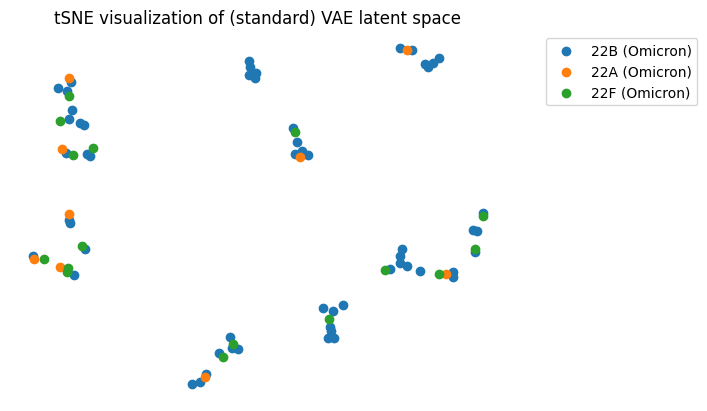

In [29]:
ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=2)
with torch.no_grad():
  Z_mean, Z_logvar = vae_model.encoder.forward(X)
  Z_mean = Z_mean.cpu()
  Z_std = torch.exp(0.5 * Z_logvar).cpu()

  max_avg_diff_mean = 0
  max_avg_diff_std = 0

  Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
  # Z_embedded = PCA().fit_transform(X=Z_mean)
  curr = 0
  for arr in indexes:
    loc_arr = list(range(curr,curr + len(arr),1))

    # print(set([clade_labels[x] for x in ranges[loc_arr]]))

    plt.scatter(Z_embedded[loc_arr,0], Z_embedded[loc_arr,1], label=clade_labels[arr[0]])
    curr += len(arr)

l1 = 0.2
l2 = 0
plt.title("tSNE visualization of (standard) VAE latent space")
plt.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))
plt.axis("off")
plt.show()

In [30]:
X = torch.tensor(new_dataset)
X = X.view(X.size(0), -1).to(DEVICE)
Z_mean, Z_logvar = vae_model.encoder.forward(X)

hamming_dists = []
euclid_dists = []

for i in range(X.size(0)):
    for j in range(i, X.size(0)):
        hamming_dists.append((X.size(1) - torch.sum(X[i,:] == X[j,:])).cpu())
        euclid_dists.append((torch.norm(Z_mean[i,:] - Z_mean[j,:])).cpu().detach())



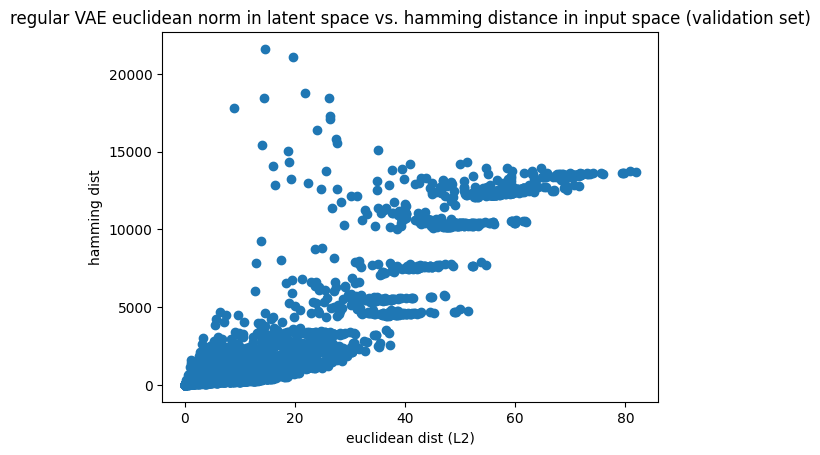

In [34]:
plt.scatter(euclid_dists, hamming_dists)
plt.title("regular VAE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("euclidean dist (L2)")
plt.ylabel("hamming dist")
plt.show()

In [32]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])

0.9223017136122835
